In [49]:
!pip install datasets transformers rouge-score nltk

import datasets
from datasets import Dataset
from datasets import load_dataset, load_metric

import nltk
nltk.download('punkt')

import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer,T5Tokenizer, T5ForConditionalGeneration
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

import re
from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
df = pd.read_csv('/kaggle/input/reddit-data/data.csv')
df.head()

,text,summary1,summary2
0,My boyfriend and I are long distance. We have ...,Mum is mad at me for not flying on my own tri...,I have made sure my mother is comfortable wit...
1,My landlord left a falsified message taped to ...,My landlord is harassing me and my neighbours...,landlord pretended to be another tenant and w...
2,"A few months ago, I asked my RA if she wanted ...","RA owes me money, made me buy her toys in a f...",RA verbally abused me and I want to get her t...
3,1) I got a DWI in 2014\n\n2) I have a wonderfu...,"10) On a scale from 1-10, how mad would you b...","I am stuck at work, my girlfriend is going to..."
4,So my wedding dress arrived last week. I had s...,"My dress looks different to how I wanted it, ...",My mother asked my dress maker to change the ...


In [51]:
df.drop_duplicates(subset = ['text'], inplace = True)
df.dropna(axis = 0, inplace = True)

df.shape

(20998, 3)

In [52]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [59]:
def text_cleaner(text):
    string = text.lower()
    string = BeautifulSoup(string, "lxml").text
    string = re.sub(r'\([^)]*\)', '', string)
    string = re.sub('"', '', string)
    string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in string.split(" ")])
    string = re.sub(r"'s\b", "", string)
    string = re.sub(r'\.{2,}', ' ', string)
    string = re.sub("[^a-zA-Z.]", " ", string)
    string = re.sub(r'\s+', ' ', string).strip()

    return string

In [60]:
cleaned_texts = []

for t in df['text']:
    cleaned_texts.append(text_cleaner(t))

/tmp/ipykernel_47/3170696000.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  string = BeautifulSoup(string, "lxml").text


In [61]:
cleaned_texts[:2]

['my boyfriend and i are long distance. we have a trip planned this summer which involves me going over to him in the usa. this will be the second time i have actually been with him in person. i am flying from the uk with my mum to the east coast. the original plan was for me to fly over to my boyfriend in the west coast but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. i even invited her on the trip with us. i have given her all of our dates so that she can travel around with us. the plan was for me to stay on the th july and fly back on the th. mum knew this. i told her i had booked a flight back already from the west coast to east coast . she has gone mad at me because she cannot believe i would book a flight when she told me she did not want me flying on my own. at the time i had booked it she told me she was not gonna road trip with us. she knew the trip was happening how else was i to get home if i do not f

In [62]:
cleaned_summaries = []

for s in df['summary1']:
    cleaned_summaries.append(text_cleaner(s))

/tmp/ipykernel_47/3170696000.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  string = BeautifulSoup(string, "lxml").text


In [63]:
cleaned_summaries[:2]

['mum is mad at me for not flying on my own trip to meet my boyfriend.',
 'my landlord is harassing me and my neighbours with the same falsified leaflets that she has done in the past. we are seeking to have the evidence examined by the human rights board of canada.']

In [64]:
cleaned_df = pd.DataFrame(columns=["text", "summary"])
cleaned_df["text"] = cleaned_texts
cleaned_df["summary"] = cleaned_summaries

cleaned_df.head()

,text,summary
0,my boyfriend and i are long distance. we have ...,mum is mad at me for not flying on my own trip...
1,my landlord left a falsified message taped to ...,my landlord is harassing me and my neighbours ...
2,a few months ago i asked my ra if she wanted t...,ra owes me money made me buy her toys in a fun...
3,i got a dwi in i have a wonderful girlfriend w...,on a scale from how mad would you be with you ...
4,so my wedding dress arrived last week. i had s...,my dress looks different to how i wanted it ho...


In [65]:
cleaned_df.replace('', np.nan, inplace=True)
cleaned_df.dropna(axis=0,inplace=True)

cleaned_df.shape

(20987, 2)

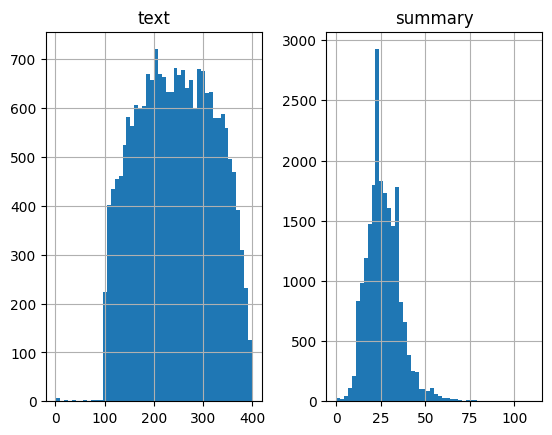

In [66]:
text_word_count = []
summary_word_count = []

for i in df['text']:
      text_word_count.append(len(i.split()))

for i in df['summary1']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 50)
plt.show()

In [67]:
base_model = 'facebook/bart-base'
tokenizer = AutoTokenizer.from_pretrained(base_model)

In [68]:
max_input_length = 400
max_target_length = 50

def preprocess_function(data):
    model_inputs = tokenizer(data['text'], max_length = max_input_length, truncation = True)

    with tokenizer.as_target_tokenizer():
        summary = tokenizer(data['summary'], max_length = max_target_length, truncation = True)

    model_inputs["labels"] = summary["input_ids"]

    return model_inputs

In [69]:
df_train, df_test = train_test_split(cleaned_df, test_size = 0.20, random_state = 42)
df_train.shape, df_test.shape

((16789, 2), (4198, 2))

In [70]:
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

len(dataset_train), len(dataset_test)

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


(16789, 4198)

In [71]:
dataset_train[0]

{'text': 'so here is the situation my girlfriend is living with her mother brother and her brother girlfriend . freeloader has her own apartment but basically just uses it as a storage room. she spends every night at my girlfirend place eats their food uses their utilities etc etc. she does no housework or help out with anything at all and does not pay rent. that is right no rent. why mom thinks her son and freeloader will get married and does not want either of them to be upset at her etc so she does not confront the issue or let her daughter say anything even though they are noticeably annoyed uncomfortable with the situation. it a lot worse than this in fact i am making freeloader look good here. i really want to confront freeloader about all this but this not being my house makes that fairly impossible since i do not want her family to be upset with me none of my business and all that but this is reckless.',
 'summary': 'i want to confront freeloader about all the stuff she does on

In [72]:
preprocess_function(dataset_train[:1])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[0, 2527, 259, 16, 5, 1068, 127, 6096, 16, 1207, 19, 69, 985, 2138, 8, 69, 2138, 6096, 479, 30270, 20657, 254, 34, 69, 308, 3537, 53, 5072, 95, 2939, 24, 25, 10, 3521, 929, 4, 79, 12500, 358, 363, 23, 127, 821, 49185, 1885, 1187, 317, 24923, 49, 689, 2939, 49, 9987, 4753, 4753, 4, 79, 473, 117, 790, 6014, 50, 244, 66, 19, 932, 23, 70, 8, 473, 45, 582, 5956, 4, 14, 16, 235, 117, 5956, 4, 596, 3795, 4265, 69, 979, 8, 30270, 20657, 254, 40, 120, 2997, 8, 473, 45, 236, 1169, 9, 106, 7, 28, 4904, 23, 69, 4753, 98, 79, 473, 45, 10749, 5, 696, 50, 905, 69, 1354, 224, 932, 190, 600, 51, 32, 28840, 26678, 9800, 19, 5, 1068, 4, 24, 10, 319, 3007, 87, 42, 11, 754, 939, 524, 442, 30270, 20657, 254, 356, 205, 259, 4, 939, 269, 236, 7, 10749, 30270, 20657, 254, 59, 70, 42, 53, 42, 45, 145, 127, 790, 817, 14, 5342, 4703, 187, 939, 109, 45, 236, 69, 284, 7, 28, 4904, 19, 162, 4146, 9, 127, 265, 8, 70, 14, 53, 42, 16, 13508, 4, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [73]:
dataset_train_tokenized = dataset_train.map(preprocess_function, batched=True)
dataset_test_tokenized = dataset_test.map(preprocess_function, batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [74]:
len(dataset_train_tokenized), len(dataset_test_tokenized)

(16789, 4198)

In [75]:
print(dataset_train_tokenized[0].keys())
print(dataset_train_tokenized[0])

dict_keys(['text', 'summary', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'])
{'text': 'so here is the situation my girlfriend is living with her mother brother and her brother girlfriend . freeloader has her own apartment but basically just uses it as a storage room. she spends every night at my girlfirend place eats their food uses their utilities etc etc. she does no housework or help out with anything at all and does not pay rent. that is right no rent. why mom thinks her son and freeloader will get married and does not want either of them to be upset at her etc so she does not confront the issue or let her daughter say anything even though they are noticeably annoyed uncomfortable with the situation. it a lot worse than this in fact i am making freeloader look good here. i really want to confront freeloader about all this but this not being my house makes that fairly impossible since i do not want her family to be upset with me none of my business and all that but t

In [76]:
metric = load_metric("rouge")
model_summ = AutoModelForSeq2SeqLM.from_pretrained(base_model)

In [77]:
def get_summary(summarizer_object, text, min_length=10, max_length=100):
    summary = [elem['summary_text'] for elem in summarizer_object(text, min_length = min_length, max_length = max_length)]
    display(HTML(pd.DataFrame({"text":text, "summary":summary}).to_html()))

In [78]:
summarizer_before_train = pipeline("summarization", model = model_summ, tokenizer = tokenizer, device = 0)

In [79]:
input_text = "This is quite good. Hello World"
cleaned_input = text_cleaner(input_text)

summarizer_before_train(cleaned_input, min_length = 3, max_length = 3)

[{'summary_text': ''}]

In [80]:
get_summary(summarizer_before_train, df_train[:1].text.tolist())

,text,summary
0,so here is the situation my girlfriend is living with her mother brother and her brother girlfriend . freeloader has her own apartment but basically just uses it as a storage room. she spends every night at my girlfirend place eats their food uses their utilities etc etc. she does no housework or help out with anything at all and does not pay rent. that is right no rent. why mom thinks her son and freeloader will get married and does not want either of them to be upset at her etc so she does not confront the issue or let her daughter say anything even though they are noticeably annoyed uncomfortable with the situation. it a lot worse than this in fact i am making freeloader look good here. i really want to confront freeloader about all this but this not being my house makes that fairly impossible since i do not want her family to be upset with me none of my business and all that but this is reckless.,so here is the situation my girlfriend is living with her mother brother and her brother girlfriend . freeloader has her own apartment but basically just uses it as a storage room. she spends every night at my girlfirend place eats their food uses their utilities etc etc. she does no housework or help out with anything at all and does not pay rent. that is right no rent. i have no idea how this is going to work out. i am not sure how this


In [81]:
get_summary(summarizer_before_train, df_test[:1].text.tolist())

,text,summary
0,i have been dating my girlfriend for about months now but we were friends for about years beforehand. we have a mutual friend and when my girlfriend hangs out with her i genuinely get upset. in the past she has tried to stop other people who were her friends from dating because it upset her. i feel like she might be trying to do that with me and my girlfriend. whenever my girlfriend hangs out with k it is this huge thing where i feel like i cannot even go into the same room as them. my girlfriend will not answer my texts because k says that it is her time. the main reason why i am upset is because k bad mouthed me in front of someone who used to have a crush on my girlfriend. that girl then proceeded to set me aside at a party and have a full blown conversation with me for over minutes that i really did not want to be a part of. whenever my girlfriend hangs out with k it feels like a little stab in the back. like she does not care that k trash talked me to someone. who knows that other shit k has said about me to other people or even to my own girlfriend i do not know what to do. everyone coddles k because she will just start crying or bitch and moan about how everyone is being mean to her but why does not anyone care about the way i feel one of these occurrences happened last night where my girlfriend and i were supposed to facetime because i am at home for a couple of weeks but she could not because k just took up all of her time.my girlfriend keeps asking me if i am mad and i am not. i am upset and hurt and i do not know how to talk to her or if i should.,i have been dating my girlfriend for about months now but we were friends for about years beforehand. we have a mutual friend and when my girlfriend hangs out with her i genuinely get upset. in the past she has tried to stop other people who were her friends from dating because it upset her. i feel like she might be trying to do that with me and my girlfriend. whenever my girlfriend hung out with k it is this huge thing where i feel that i cannot even go into the same


In [ ]:
# !pip install accelerate -U
!pip install transformers[torch] accelerate -U

In [82]:
batch_size = 8
epochs = 5

args = Seq2SeqTrainingArguments('summarization_bart_V2',
                                num_train_epochs = epochs,
                                evaluation_strategy = "epoch",
                                logging_steps = 100,
                                learning_rate = 2e-5,
                                weight_decay = 0.01,
                                per_device_train_batch_size = batch_size,
                                per_device_eval_batch_size = batch_size,
                                save_total_limit = 3,
                                predict_with_generate = True,
                                fp16 = True
                                )

In [83]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens = True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions = decoded_preds, references = decoded_labels, use_stemmer = True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [84]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model_summ)

In [85]:
model_trainer = Seq2SeqTrainer(model_summ,
                               args,
                               train_dataset = dataset_train_tokenized,
                               eval_dataset = dataset_test_tokenized,
                               data_collator = data_collator,
                               tokenizer = tokenizer,
                               compute_metrics = compute_metrics)

In [86]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_summ.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [87]:
device

device(type='cuda')

In [88]:
model_trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.412000,2.146006,34.115000,13.368900,26.995700,28.994800,28.919000
2,2.187900,2.102586,34.435100,13.552100,26.963300,29.245200,34.941600
3,2.121400,2.094026,34.400100,13.536900,26.987100,29.372200,34.358000
4,2.027000,2.082776,34.724800,13.691400,27.234300,29.548900,33.627200
5,1.956100,2.080650,34.766400,13.701900,27.247600,29.549000,33.683400


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=5250, training_loss=2.176535834902809, metrics={'train_runtime': 6028.1853, 'train_samples_per_second': 13.925, 'train_steps_per_second': 0.871, 'total_flos': 1.940077981191168e+16, 'train_loss': 2.176535834902809, 'epoch': 5.0})

In [89]:
PATH = '/kaggle/working/summarization_bart/' + 'BART_V2'

if not os.path.isdir(PATH):
    os.mkdir(PATH)
    model_summ.save_pretrained(PATH)
else:
    print('Model already exists')

In [90]:
summarizer = pipeline("summarization", model = model_summ, tokenizer = tokenizer, device = 0)

In [91]:
idx = random.sample(range(0, len(df_test)), k=3)
get_summary(summarizer, df_test.iloc[idx].text.tolist())

,text,summary
0,so my father has been struggling with an unknown skin condition for the past few months. after several doctors visits referrals prescriptions and trying every home remedy and lotion under the sun it has persisted. the skin is almost leather like and very thick from his face all the way down his arms chest and back and he develops painful lumps or nodules under the skin that grow and shrink at various spots along the neck front shoulder and upper arm. these lumps start the size of a pea and grow to small ping pong balls and then shrink again over the course of a few days time. he was referred to have an outpatient surgery early last week to remove one of these lumps so that they could perform a biopsy and find out what exactly is going on with him. he returned today to have his stitches removed and find out some preliminary results. the doctor very frankly said that he was sorry but they have lost the sample that they extracted from his body. no recourse was offered and my father left the office completely stunned at the situation after having the stitches removed. the surgery referral was covered by his medicare and supplementary insurance all but . . now this is not an obscene amount but we are by no means well off. but i find it very disturbing that my father is still left with no idea of what is wrong with him and now will most likely have to undergo another surgery in the near future. is there anything i can do reddit is this grounds for a negligence or malpractice lawsuit i know that this is no place for seeking legal advice but there has to be someone out there that might have gone through something similar or can offer some advice.,my father has a skin condition that is causing him to develop painful lumps under the skin that grow and shrink over the course of a few days time. is this grounds for negligence or malpractice lawsuit
1,hi all. my boyfriend and i have been dating for sixteen months. we would be hypothetically moving in together in august. apartments in our city are very expensive and it would make good financial sense for us to live together and split rent not only for me but for him since he is graduating this year and will have to start paying his own rent as soon as he leaves school . living with him would reassure my parents about my safety which they would otherwise worry about. he is also dealing with a difficult roommate at his current place and i think he would be eager to leave the situation. i just have two reservations. one is that i do not know if i want to think about a serious future with a guy i met when i was nineteen and i feel like moving in together is a precursor to that. another is that we had been having difficulties lately due to how he was treating me due to his own insecurities. at one point i was so upset i was thinking about breaking up with him. but after a come to jesus talk a month ago he sincerely apologized to me and acknowledged that he was behaving wrongly ever since he has been making a marked effort to do better and it has really helped. but i just worry that having this feelings so recently makes moving in together a bad idea. what do you guys think,my boyfriend and i would like to move in together but i do not know if i should.
2,hi all a few quick questions i met this girl through a couple of friends. we did not talk much that first night but we have some mutual friends and they said she is awesome. i liked her enough to ask her out we went on a first date about weeks ago. it was really pleasant i felt very relaxed but excited to hang out with her. she was traveling in europe for past . weeks but she has since returned. we went on a second date yesterday . i had a great time last night and i would like to ask her out again. i have not really dated very much . so here are my questions . i did not make a move last time because i felt like she is a conservative girl and also since i had not seen her in almost weeks i personally felt like holding off. that i

In [92]:
text_test = df_test.text.tolist()
summary_test = df_test.summary.tolist()
summary_pred = []

In [93]:
batch_size = 8
start_idx = 0

for i in range(0, len(text_test[start_idx:]), batch_size):
    batch = int(i/batch_size)
    batch_text = text_test[start_idx+i : start_idx+i+batch_size]
    summary_pred += [elem['summary_text'] for elem in summarizer(batch_text, min_length = 10, max_length = 100)]
    if batch == 2:
        break

In [94]:
results = metric.compute(predictions = summary_pred, references = summary_test[:len(summary_pred)])
print(results)

for key in ["rouge1", "rouge2", "rougeL"]:
    print(key, "low:", results[key].low.fmeasure)
    print(key, "mid:", results[key].mid.fmeasure)
    print(key, "high:", results[key].high.fmeasure, end = "\n\n")

{'rouge1': AggregateScore(low=Score(precision=0.2505264454364212, recall=0.23443359057769433, fmeasure=0.23574849763354172), mid=Score(precision=0.31201279234813906, recall=0.29695213106650087, fmeasure=0.28957322729277857), high=Score(precision=0.3728719710399387, recall=0.359007748628315, fmeasure=0.34227680588413006)), 'rouge2': AggregateScore(low=Score(precision=0.059058813654305806, recall=0.05866374059924952, fmeasure=0.056619296142510094), mid=Score(precision=0.10090368717346346, recall=0.09545273536539481, fmeasure=0.09448165955439926), high=Score(precision=0.14634366655767964, recall=0.14131589721724733, fmeasure=0.13714516404594537)), 'rougeL': AggregateScore(low=Score(precision=0.19535077380956425, recall=0.18342693648447086, fmeasure=0.18412867058722365), mid=Score(precision=0.24618145305323555, recall=0.22695072303511565, fmeasure=0.22526707796606), high=Score(precision=0.3050846434208583, recall=0.2777597843251218, fmeasure=0.2770433329788212)), 'rougeLsum': AggregateScor

In [95]:
rouge1 = []
rouge2 = []
rougeL = []

for i in range(len(summary_pred)):
    results = metric.compute(predictions = [summary_pred[i]], references = [summary_test[i]])
    for key in ["rouge1", "rouge2", "rougeL"]:
        if key == "rouge1":
            rouge1.append(results[key].mid.fmeasure)
        elif key == "rouge2":
            rouge2.append(results[key].mid.fmeasure)
        else:
            rougeL.append(results[key].mid.fmeasure)

In [96]:
n = len(summary_pred)
df_results_sample = pd.DataFrame({"text": text_test[:n],
                                 "summary": summary_test[:n],
                                 "summary_pred": summary_pred[:n],
                                 "rouge1": rouge1,
                                 "rouge2": rouge2,
                                 "rougeL": rougeL}
                                 )

df_results_sample.head()

,text,summary,summary_pred,rouge1,rouge2,rougeL
0,i have been dating my girlfriend for about mon...,gf hangs out with a mutual friend who used to ...,my girlfriend hangs out with a friend and i fe...,0.264151,0.117647,0.226415
1,he is a classmate. he is never had a girlfrien...,i have been with guys and have been in abusive...,i am in love with a classmate but i do not kno...,0.285714,0.000000,0.190476
2,i need to some help. sometimes i feel like i c...,i maybe still in love with my abusive ex and i...,i am a year old female and i am in a relations...,0.395062,0.202532,0.271605
3,reddit i come to you for advice. below is a cl...,friend is in a bad relationship and keeps comi...,my best friend is in a toxic emotionally abusi...,0.400000,0.150943,0.290909
4,me m her f him m . i asked out my female best ...,want to tell my best friend that i am going ou...,i am dating my female best friend. we are both...,0.448980,0.170213,0.204082


In [97]:
text = """I 27F am vehemently childfree, I am sterilized and have no intention of having or caring for any child. I married my husband, 33M, last year and did not know he had any children until 5 days ago. I travel for work, work for myself, and have amazing pay for very few active working hours (I am a honeymoon planner, owning my own business); we have a joint account for bills and our own separate accounts for savings and fun money.

My husband sat me down 5 days ago and told me he hadn't been completely honest with me. And revealed he has 2 children 10M and 7F. He pays regular child support, however, it dips into his fun money and he wants to be able to have fun like I am, so he said he would fight for 50/50 custody.

I was furious he had lied to me and was even more angry when he told me he wanted 50/50. He works 12-16 hour shifts as a nurse and that would mean I would have to take care of the children when I'm not working or are working from home. I told him if he fights for custody, I will leave him. We have a prenup, so a divorce will be rather simple; I get 100% of my business, all of my savings and fun money, and the house, as I inherited it from my grandmother.

He called me an asshole and told me I should step up so that he can have more money in his savings and for fun. And because the kids won't be much hassle due to their ages. So AITA for telling him I will divorce him if he goes through with filing for custody?"""

text = text_cleaner(text)

In [102]:
get_summary(summarizer, text)

,text,summary
0,i f am vehemently childfree i am sterilized and have no intention of having or caring for any child. i married my husband m last year and did not know he had any children until days ago. i travel for work work for myself and have amazing pay for very few active working hours we have a joint account for bills and our own separate accounts for savings and fun money. my husband sat me down days ago and told me he had not been completely honest with me. and revealed he has children m and f. he pays regular child support however it dips into his fun money and he wants to be able to have fun like i am so he said he would fight for custody. i was furious he had lied to me and was even more angry when he told me he wanted . he works hour shifts as a nurse and that would mean i would have to take care of the children when i am not working or are working from home. i told him if he fights for custody i will leave him. we have a prenup so a divorce will be rather simple i get of my business all of my savings and fun money and the house as i inherited it from my grandmother. he called me an asshole and told me i should step up so that he can have more money in his savings and for fun. and because the kids will not be much hassle due to their ages. so aita for telling him i will divorce him if he goes through with filing for custody,husband lied to me about having children i told him i will divorce him if he goes through with filing for custody.


In [103]:
get_summary(summarizer, df_train[1:2].text.tolist())

,text,summary
0,i normally do not let things get to me but i am obsessing over minor issues today first the gas station with free air started charging for air. then the dog failed to greet me when i got home. and bobfromaccounting.com has apparently departed the internet. the gas station and i have an understanding i pay the cents more for gas on my debit card and i do not have to keep quarters stocked for the air machine. and yeah it is more of a tacit agreement than what you call a contract but dammit we had a deal. the dog is supposed to be jumping up and down in the window as i drive up making high pitched doggy squeals as i put my key in the lock barely able to contain herself as she waits for me to stash my purse and laptop before greeting her. after years she is getting a little old for the happy dance but dozing on the bed finally after a conversation with my sister i was reminded of something i once read and went to the site to send her a link only to discover the site is gone. wtf internet you may not be permanent but i always thought i could count on you to be redundant. i was confident a quick search would find a cache a mirror a plagiarized ripoff. something anything if it exists my google goggles are too clouded to find it today. none of these is anything that matters. truly a roll of quarters a milk bone and a shrug are all that i really need. so why am i still thinking about these things,bobfromaccounting.com is gone. why am i still thinking about it


In [100]:
df_results_sample['summary'][0]

'gf hangs out with a mutual friend who used to have a crush on her. i am upset that she hangs out with this girl.'

In [101]:
df_results_sample['summary_pred'][0]

'my girlfriend hangs out with a friend and i feel like i cannot even go into the same room as them. i do not know what to do.'